In this notebook you will find an implementation of DCGANs as described in the paper of Radford et al. "Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks"

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.utils
from torchvision.utils import make_grid

import torchvision.datasets

import matplotlib.pyplot as plt 
plt.rcParams["figure.figsize"] = (10,6)

from tqdm import tqdm 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
batch_size = 128 # Images per batch

# Resize to 32x32 for easier upsampling/downsampling
mytransform = transforms.Compose([transforms.Resize(32),
                                  transforms.ToTensor(),
                                 transforms.Normalize((.5), (.5))]) # normalize between [-1, 1] with tanh activation

mnist_train = torchvision.datasets.MNIST(root='.', download=True, transform=mytransform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
dataloader = DataLoader(dataset=mnist_train, 
                         batch_size=batch_size,
                         shuffle=True)    

In [4]:
real_batch, real_labels = next(iter(dataloader))

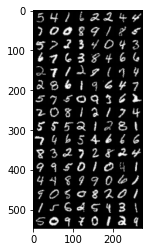

In [5]:
plt.imshow(transforms.ToPILImage()(make_grid(real_batch)))

In [6]:
def get_upscaling_block(channels_in, channels_out, kernel, stride, padding, last_layer=False):
    '''
    Each transpose conv will be followed by BatchNorm and ReLU, 
    except the last block (which is only followed by tanh)
    '''
    if last_layer:
        model = nn.Sequential(
          nn.ConvTranspose2d(channels_in, channels_out, kernel_size=kernel, stride=stride, padding=padding),
          nn.Tanh(),
        )
    else:
        model = nn.Sequential(
          nn.ConvTranspose2d(channels_in, channels_out, kernel_size=kernel, stride=stride, padding=padding),
          nn.BatchNorm2d(channels_out),
          nn.ReLU(),
        )
    return model




class Generator(nn.Module):
    def __init__(self, nz, ngf, nchannels=1):
        '''
        nz: The latent size (100 in our case)
        ngf: The channel-size before the last layer (32 our case)
        '''
        super().__init__()
        
        
        self.model = nn.Sequential(
            get_upscaling_block(nz, ngf*4, 4, 1, 0),
            get_upscaling_block(ngf*4, ngf*2, 4, 2, 1),
            get_upscaling_block(ngf*2, ngf, 4, 2, 1),
            get_upscaling_block(ngf, nchannels, 4, 2, 1, last_layer=True)
        )
        
    def forward(self, z):
        x = z.unsqueeze(2).unsqueeze(2) 
        return self.model(x)
        

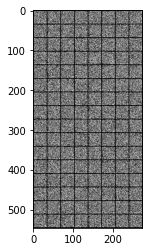

In [7]:
nz = 1000
z = torch.randn(batch_size, nz)
G = Generator(nz=nz, ngf=16)
x_fake = G(z)
plt.imshow(transforms.ToPILImage()(make_grid(x_fake, nrow=8)))

In [8]:
def get_downscaling_block(channels_in, channels_out, kernel, stride, padding, use_batch_norm=True, is_last=False):
    
    if is_last:
        model = nn.Sequential(
          nn.Conv2d(channels_in, channels_out, kernel_size=kernel, stride=stride, padding=padding),
          nn.Sigmoid(),
        )
    
    elif not use_batch_norm:
        model = nn.Sequential(
          nn.Conv2d(channels_in, channels_out, kernel_size=kernel, stride=stride, padding=padding),
          nn.LeakyReLU(0.2),
        )
    
    else:
        model = nn.Sequential(
          nn.Conv2d(channels_in, channels_out, kernel_size=kernel, stride=stride, padding=padding),
          nn.BatchNorm2d(channels_out),
          nn.LeakyReLU(0.2),
        )
    return model
    
    


class Discriminator(nn.Module):
    def __init__(self, ndf, nchannels=1, ncin=1):
        super().__init__()
        
        
        self.model = nn.Sequential(
            get_downscaling_block(ncin, ndf, 4, 2, 1),
            get_downscaling_block(ndf, ndf*2, 4, 2, 1),
            get_downscaling_block(ndf*2, ndf*4, 4, 2, 1),
            get_downscaling_block(ndf*4, nchannels, 4, 1, 0, is_last=True)
        )


    def forward(self, x):
        return self.model(x).squeeze(1).squeeze(1)

In [9]:
criterion = nn.BCELoss()

In [10]:
def sample_z(batch_size, nz):
    return torch.randn(batch_size, nz, device=device)

# this is for the real ground-truth label
def get_labels_one(batch_size):
    r = torch.ones(batch_size, 1)
    return r.to(device)

# this is for the generated ground-truth label
def get_labels_zero(batch_size):
    r = torch.zeros(batch_size, 1) 
    return r.to(device)


# To initialize the weights of a GAN, the DCGAN paper found that best results are obtained
# with Gaussian initialization with mean=0; std=0.02
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        

# for visualization
to_pil = transforms.ToPILImage()
renorm = transforms.Normalize((-1.), (2.))

In [11]:
nz = 100
ngf = 32
ndf = 32

nchannels= 1 
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))

it: 0; g_loss: 1.0467863082885742; d_loss: 1.4277411699295044; avg_real_score: 0.5401831865310669; avg_fake_score: 0.37749290466308594: : 0it [00:00, ?it/s]

generated images


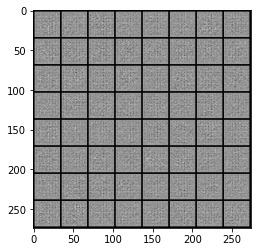

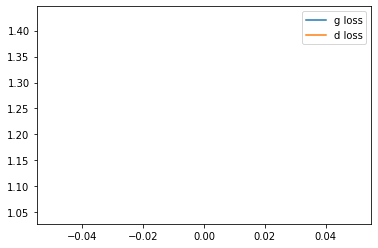

it: 200; g_loss: 2.013592004776001; d_loss: 0.5334506034851074; avg_real_score: 0.7908188104629517; avg_fake_score: 0.1477254033088684: : 200it [00:28,  7.21it/s] 

generated images


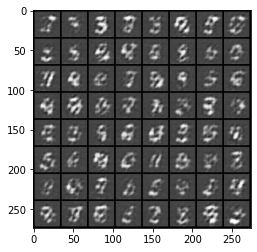

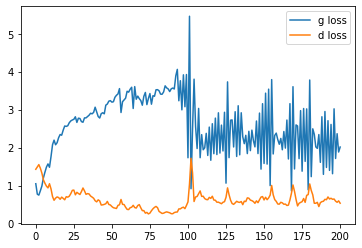

it: 400; g_loss: 2.8203020095825195; d_loss: 0.3596324324607849; avg_real_score: 0.9409791231155396; avg_fake_score: 0.0678117573261261: : 400it [00:58,  7.25it/s]

generated images


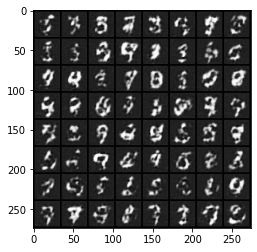

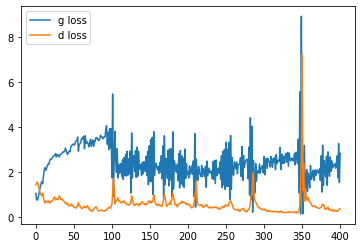

it: 468; g_loss: 1.2728054523468018; d_loss: 0.8196952939033508; avg_real_score: 0.4900723695755005; avg_fake_score: 0.310008704662323: : 469it [01:08,  6.83it/s]
it: 469; g_loss: 6.266432762145996; d_loss: 0.9950950145721436; avg_real_score: 0.9759033918380737; avg_fake_score: 0.00289430795237422: : 0it [00:00, ?it/s]

generated images


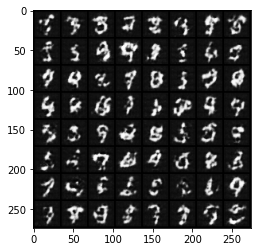

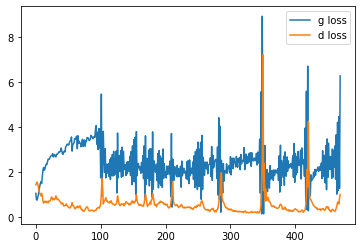

it: 669; g_loss: 0.6836464405059814; d_loss: 2.189027786254883; avg_real_score: 0.14909622073173523; avg_fake_score: 0.5213757157325745: : 200it [00:29,  6.84it/s]

generated images


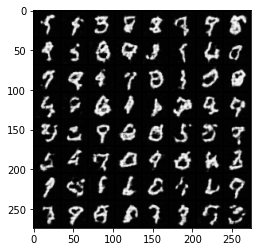

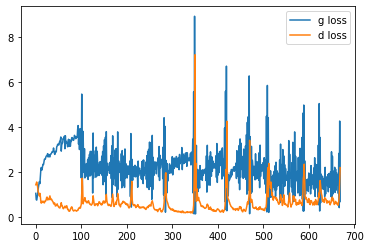

it: 869; g_loss: 1.8000141382217407; d_loss: 0.9025565385818481; avg_real_score: 0.8045399188995361; avg_fake_score: 0.17855894565582275: : 400it [00:58,  7.07it/s]

generated images


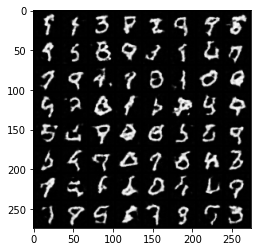

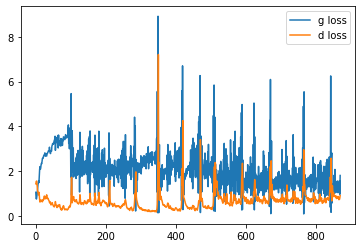

it: 937; g_loss: 1.5690287351608276; d_loss: 0.7793462872505188; avg_real_score: 0.6378414034843445; avg_fake_score: 0.23432162404060364: : 469it [01:09,  6.79it/s]
it: 938; g_loss: 2.3250222206115723; d_loss: 0.66713547706604; avg_real_score: 0.748570442199707; avg_fake_score: 0.11714376509189606: : 0it [00:00, ?it/s]

generated images


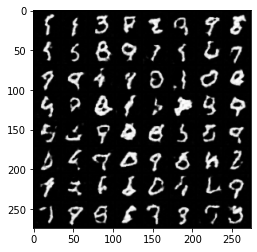

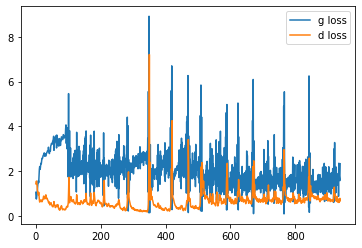

it: 1138; g_loss: 2.0212650299072266; d_loss: 0.5629409551620483; avg_real_score: 0.7919796109199524; avg_fake_score: 0.1550719439983368: : 200it [00:29,  6.88it/s]

generated images


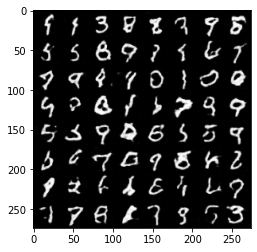

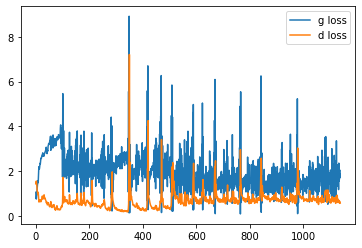

it: 1338; g_loss: 1.6478321552276611; d_loss: 0.6049346923828125; avg_real_score: 0.6851942539215088; avg_fake_score: 0.217399001121521: : 400it [00:59,  6.80it/s]

generated images


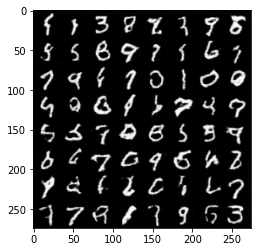

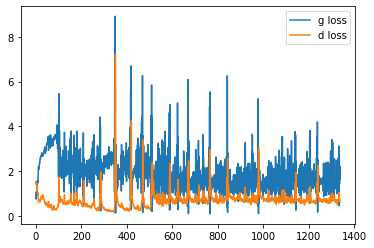

it: 1406; g_loss: 1.8859632015228271; d_loss: 0.5879930257797241; avg_real_score: 0.7828279733657837; avg_fake_score: 0.1714119166135788: : 469it [01:10,  6.67it/s]
it: 1407; g_loss: 1.8788142204284668; d_loss: 0.4736715257167816; avg_real_score: 0.7792924046516418; avg_fake_score: 0.1762382984161377: : 0it [00:00, ?it/s]

generated images


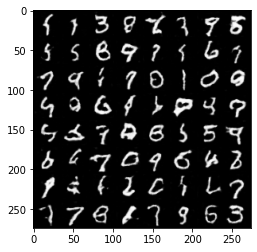

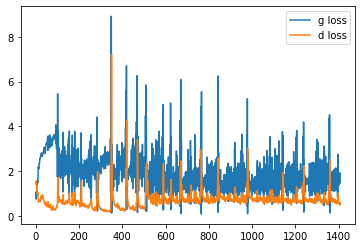

it: 1607; g_loss: 3.4267492294311523; d_loss: 0.680033802986145; avg_real_score: 0.9382228851318359; avg_fake_score: 0.03924562409520149: : 200it [00:30,  6.40it/s]

generated images


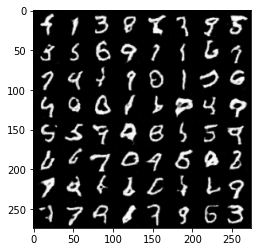

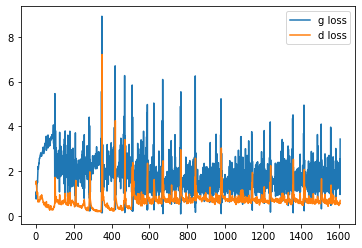

it: 1807; g_loss: 1.1833709478378296; d_loss: 0.6980491280555725; avg_real_score: 0.6200043559074402; avg_fake_score: 0.3308729827404022: : 400it [01:01,  6.71it/s]

generated images


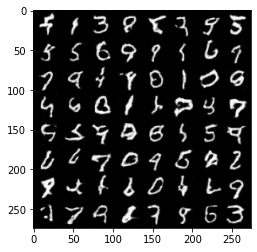

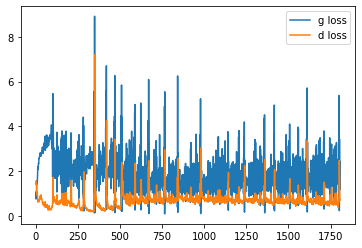

it: 1875; g_loss: 1.2901849746704102; d_loss: 0.7964978218078613; avg_real_score: 0.5319048762321472; avg_fake_score: 0.2990306615829468: : 469it [01:12,  6.45it/s]
it: 1876; g_loss: 1.979216456413269; d_loss: 0.6878508925437927; avg_real_score: 0.8502927422523499; avg_fake_score: 0.15451261401176453: : 0it [00:00, ?it/s]

generated images


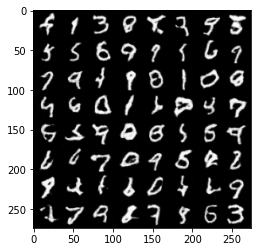

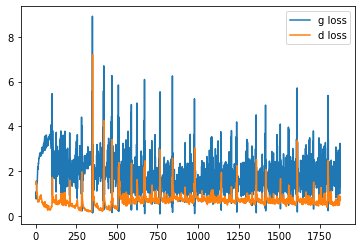

it: 2076; g_loss: 1.82330322265625; d_loss: 1.0379647016525269; avg_real_score: 0.5890454053878784; avg_fake_score: 0.19325411319732666: : 200it [00:31,  6.79it/s]

generated images


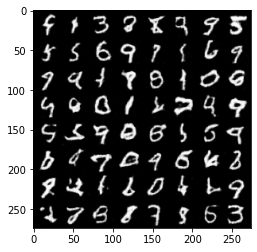

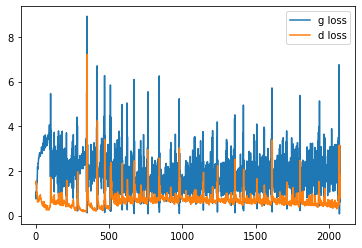

it: 2276; g_loss: 3.191795587539673; d_loss: 0.41930264234542847; avg_real_score: 0.9213863015174866; avg_fake_score: 0.051335372030735016: : 400it [01:02,  6.65it/s]

generated images


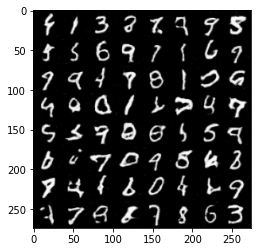

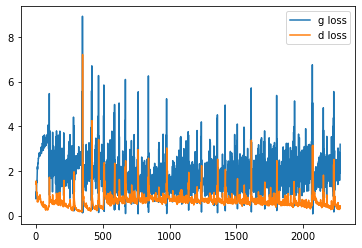

it: 2344; g_loss: 2.7493808269500732; d_loss: 0.36449509859085083; avg_real_score: 0.9158985018730164; avg_fake_score: 0.0756942480802536: : 469it [01:12,  6.44it/s]


In [12]:
nb_epochs = 5
g_losses = []
d_losses = []
j = 0
z_test = sample_z(64, nz) # we generate the noise only once for testing
for epoch in range(nb_epochs):

    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch 
        im = im.to(device)
        
        cur_batch_size = im.shape[0]  
        with torch.autograd.set_detect_anomaly(True):
            # 1. sample a z vector 
            z = torch.randn(cur_batch_size, nz).to(device)
            
            # 2. Generate a fake image
            fake_image = netG(z)

            # 3. Classify real image with D
            yhat_real = netD(im)

            # 4. Classify fake image with D
            yhat_fake = netD(fake_image.detach())
            
            
            ###
            ### Discriminator
            ###
            real_labels = torch.ones((cur_batch_size, 1)).to(device)
            fake_labels = torch.zeros((cur_batch_size, 1)).to(device)

            d_loss = criterion(yhat_real, real_labels) 
            d_loss = d_loss + criterion(yhat_fake, fake_labels)
            
            d_opt.zero_grad()
            d_loss.backward() 
            d_opt.step()
            
            ###
            ### Generator
            ###
            yhat_fake = netD(fake_image)
            g_loss = criterion(yhat_fake, real_labels) 
            
            g_opt.zero_grad()
            g_loss.backward()
            g_opt.step()
        
        
        # Save Metrics
        
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        
        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)
            
            un_norm = renorm(fake_im) # for visualization
            
            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)  
            
            print("generated images")
            plt.imshow(pil_grid)
            plt.show()
            
            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')
            
            plt.legend()
            plt.show()
            
        j += 1